In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

2022-08-11 11:06:22.265489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-11 11:06:22.265516: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
input_df = pd.read_csv("input_data_nn.csv", sep=";")
output_df = pd.read_csv("output_data_nn.csv", sep=";")

In [5]:
df = pd.concat([input_df, output_df], axis=1)

In [6]:
test_split=round(len(df)*0.30)
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(6132, 51)
(2628, 51)


In [7]:
scaler = MinMaxScaler(feature_range=(-1,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)

In [24]:
def run(df, cols, max_id, model_id, days):
    _df = df[cols]
    
    test_split=round(len(df)*0.30)
    df_for_training=_df[:-test_split]
    df_for_testing=_df[-test_split:]
    
    #scaler = MinMaxScaler(feature_range=(0,1))
    scaler = StandardScaler()
    df_for_training_scaled = scaler.fit_transform(df_for_training)
    df_for_testing_scaled = scaler.transform(df_for_testing)
    
    trainX, trainY = window(days * 24, max_id, df_for_training_scaled)
    testX, testY = window(days * 24, max_id, df_for_testing_scaled) 
    print(trainX.shape[1])
    
    print(f" ========== MODEL {model_id} ============")
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = ModelCheckpoint(f"models/{model_id}.h5", monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    
    grid_model = Sequential()
    grid_model.add(LSTM(trainX.shape[1], return_sequences = True, input_shape=(24 * days, trainX.shape[-1])))
    grid_model.add(Dense(int(trainX.shape[1])))
    grid_model.add(LSTM(int(trainX.shape[1] / 2)))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(max_id))

    grid_model.compile(loss = 'mae', optimizer = 'adam')
    grid_model.fit(
        trainX, trainY,
        batch_size = 5, epochs = 13,
        callbacks = [es, mc],
        validation_data = (testX, testY)
    )

    print()
    
def window(n_past, max_id, dataset):
    dataX = []
    dataY = []
    
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[(i - n_past):i])
        dataY.append(dataset[i, 0:max_id])
        
    return np.array(dataX), np.array(dataY)

In [19]:
cols_1 = [
    #'pot_ativa_inj_barramento11',
    # 'pot_ativa_inj_barramento24',  
    # 'pot_reativa_inj_barramento11',
    'pot_ativa_inj_barramento24',
    'pot_reativa_inj_barramento24',
    # 'pot_reativa_inj_barramento24',  
    # 'tensao_barramento11',
     'tensao_barramento24',
    # 'tensao_barramento24',
     'carga_subrede_138kv',
     'pot_eolica_subrede_138kv',
     'pot_solar_subrede_138kv'
]
cols_2 = [
    'pot_ativa_inj_barramento11',
    # 'pot_ativa_inj_barramento12',
    # 'pot_ativa_inj_barramento24',  
    # 'pot_reativa_inj_barramento11',
    # 'pot_reativa_inj_barramento12',
    # 'pot_reativa_inj_barramento24',  
#      'tensao_barramento11',
#      'tensao_barramento12',
#      'tensao_barramento24',
     'carga_subrede_138kv',
     'pot_eolica_subrede_138kv',
     'pot_solar_subrede_138kv'
]
cols_3 = [
    'pot_ativa_inj_barramento11',
    # 'pot_ativa_inj_barramento12',
    # 'pot_ativa_inj_barramento24',  
     'pot_reativa_inj_barramento11',
    # 'pot_reativa_inj_barramento12',
    # 'pot_reativa_inj_barramento24',  
     'tensao_barramento11',
    # 'tensao_barramento12',
    # 'tensao_barramento24',
     'carga_subrede_138kv',
     'pot_eolica_subrede_138kv',
     'pot_solar_subrede_138kv'
]

In [25]:
#print("=== 70 DAYS ====")
#run(df, cols_1, 1, 1, 70)
#run(df, cols_2, 1, 2, 70)
#run(df, cols_3, 1, 3, 70)
#run(df, cols_4, 1, 4, 70)
#run(df, cols_5, 1, 5, 70)
run(df, cols_1, 1, 'bus-24-active-only-5batch', 5)

#print("=== 10 DAYS ====")
#run(df, cols_1, 1, 7, 10)
#run(df, cols_2, 1, 8, 10)
#run(df, cols_3, 1, 9, 10)
#run(df, cols_4, 1, 10, 10)
#run(df, cols_5, 1, 11, 10)
#run(df, cols_6, 1, 12, 10)

# print("=== 40 DAYS ====")
# run(df, cols_1, 1, 13, 40)
# run(df, cols_2, 1, 14, 40)
# run(df, cols_3, 1, 15, 40)
# run(df, cols_4, 1, 16, 40)
# run(df, cols_5, 1, 17, 40)
# run(df, cols_6, 1, 18, 40)

120
 ========== MODEL bus-24-active-only-5batch ============
Epoch 1/13
1203/1203 [==============================] - ETA: 0s - loss: 0.3702
Epoch 1: val_loss improved from inf to 0.29709, saving model to models/bus-24-active-only-5batch.h5
1203/1203 [==============================] - 83s 67ms/step - loss: 0.3702 - val_loss: 0.2971
Epoch 2/13
1203/1203 [==============================] - ETA: 0s - loss: 0.2936
Epoch 2: val_loss improved from 0.29709 to 0.27565, saving model to models/bus-24-active-only-5batch.h5
1203/1203 [==============================] - 109s 91ms/step - loss: 0.2936 - val_loss: 0.2757
Epoch 3/13
1203/1203 [==============================] - ETA: 0s - loss: 0.2803
Epoch 3: val_loss did not improve from 0.27565
1203/1203 [==============================] - 85s 70ms/step - loss: 0.2803 - val_loss: 0.2831
Epoch 4/13
1203/1203 [==============================] - ETA: 0s - loss: 0.2715
Epoch 4: val_loss improved from 0.27565 to 0.26729, saving model to models/bus-24-active-onl

In [89]:
days = 25 * 3
max_idx_pred = 1

In [90]:
def window(n_past, max_id, dataset):
    dataX = []
    dataY = []
    
    for i in range(n_past, len(dataset)):
        dataX.append(dataset[(i - n_past):i])
        dataY.append(dataset[i, 0:max_id])
        
    return np.array(dataX), np.array(dataY)
        
trainX, trainY = window(days * 24, max_idx_pred, df_for_training_scaled)
testX, testY = window(days * 24, max_idx_pred, df_for_testing_scaled)

print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

trainX Shape--  (4332, 1800, 9)
trainY Shape--  (4332, 1)
testX Shape--  (828, 1800, 9)
testY Shape--  (828, 1)


## ANN

In [32]:
trainY, trainX = df_for_training_scaled[:,:3], df_for_training_scaled[:,3:]
testY, testX = df_for_testing_scaled[:,:3], df_for_testing_scaled[:,3:]

In [31]:
trainY.shape, trainX.shape

((6132, 3), (6132, 9))

In [73]:
def build_model_ann(output_dim, callbacks):    
    model = Sequential()
    model.add(Input(shape=(trainX.shape[1],)))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = 'relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(output_dim, activation = 'softmax'))
        
    model.compile(loss = 'mse', optimizer = 'adam')
    model.fit(
        trainX, trainY,
        batch_size = 16, epochs = 20,
        callbacks = callbacks,
        validation_data = (testX, testY)
    )
    
    return model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('models/ann_mse.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

output_dim = 3
model = build_model_ann(output_dim, [es, mc])

prediction=model.predict(testX)

Epoch 1/20
360/384 [===========================>..] - ETA: 0s - loss: 0.0391
Epoch 1: val_loss improved from inf to 0.04776, saving model to models/ann_mse.h5
384/384 [==============================] - 1s 2ms/step - loss: 0.0389 - val_loss: 0.0478
Epoch 2/20
363/384 [===========================>..] - ETA: 0s - loss: 0.0385
Epoch 2: val_loss improved from 0.04776 to 0.04769, saving model to models/ann_mse.h5
384/384 [==============================] - 1s 2ms/step - loss: 0.0384 - val_loss: 0.0477
Epoch 3/20
349/384 [==========================>...] - ETA: 0s - loss: 0.0388
Epoch 3: val_loss improved from 0.04769 to 0.04767, saving model to models/ann_mse.h5
384/384 [==============================] - 1s 2ms/step - loss: 0.0383 - val_loss: 0.0477
Epoch 4/20
355/384 [==========================>...] - ETA: 0s - loss: 0.0383
Epoch 4: val_loss improved from 0.04767 to 0.04766, saving model to models/ann_mse.h5
384/384 [==============================] - 1s 2ms/step - loss: 0.0383 - val_loss: 0.0

In [60]:
def inverse_transform(testX, arrs):
    zeros_padding = np.zeros(testX.shape[-1])
    arrs_copies = list(map(lambda arr: np.concatenate((arr, zeros_padding)), arrs))
    return scaler.inverse_transform(np.reshape(arrs_copies, (len(arrs), 12)))

In [74]:
predicted = inverse_transform(testX, prediction)

In [75]:
original = inverse_transform(testX, testY)

In [78]:
index = 1
mean_absolute_error(original[:,index], predicted[:,index])

43.30859041768356

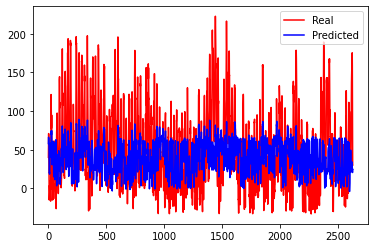

In [79]:
def _plot(orig, pred):
    plt.plot(orig, color = 'red', label = 'Real')
    plt.plot(pred, color = 'blue', label = 'Predicted')
    plt.legend()
    plt.show()
_plot(original[:,index], predicted[:,index])

In [66]:
original[45], predicted[45]

(array([ 42.69495459,  16.73024948,  85.96972508, -36.46508011,
        -80.51506356,  -8.81323327,   0.95      ,   0.95      ,
          0.95      , 502.85878985,  29.88406527,   0.        ]),
 array([ 47.97461249,  21.78558481,  94.12311499, -36.46508011,
        -80.51506356,  -8.81323327,   0.95      ,   0.95      ,
          0.95      , 502.85878985,  29.88406527,   0.        ]))

## Grid search

In [163]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,51)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    # {'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}
    grid_model.fit(trainX,trainY, batch_size =  16, epochs = 10,validation_data=(testX, testY))
    
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))

parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)


grid_search = grid_search.fit(trainX,trainY)
grid_search.best_params_
my_model=grid_search.best_estimator_.model

/tmp/ipykernel_10384/1044546172.py:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))


In [305]:
prediction_copies_array = np.repeat(prediction, 25, axis=1)
prediction_copies_array_m = list(map(lambda pred: (pred.tolist() * 25) + [pred.tolist()[0]], prediction))
pred = scaler.inverse_transform(np.reshape(prediction_copies_array_m,(len(prediction),51)))[:,1]

In [35]:
def build_model_cv(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(24 * days, trainX.shape[-1])))
    #grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(max_idx_pred))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    
    return grid_model

grid_model = KerasRegressor(build_fn=build_model_cv,verbose=1,validation_data=(testX,testY))

parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

grid_search = grid_search.fit(trainX,trainY)
grid_search.best_params_
my_model=grid_search.best_estimator_.model

/tmp/ipykernel_7967/479307926.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model_cv,verbose=1,validation_data=(testX,testY))


Epoch 1/8
188/188 [==============================] - 25s 123ms/step - loss: 0.0305 - val_loss: 0.0203
Epoch 2/8
188/188 [==============================] - 24s 130ms/step - loss: 0.0139 - val_loss: 0.0158
Epoch 3/8
188/188 [==============================] - 24s 130ms/step - loss: 0.0107 - val_loss: 0.0110
Epoch 4/8
188/188 [==============================] - 23s 122ms/step - loss: 0.0087 - val_loss: 0.0106
Epoch 5/8
188/188 [==============================] - 22s 119ms/step - loss: 0.0078 - val_loss: 0.0091
Epoch 6/8
188/188 [==============================] - 23s 121ms/step - loss: 0.0068 - val_loss: 0.0071
Epoch 7/8
188/188 [==============================] - 23s 123ms/step - loss: 0.0066 - val_loss: 0.0079
Epoch 8/8
188/188 [==============================] - 6s 34ms/step - loss: 0.0076
Epoch 1/8
188/188 [==============================] - 25s 119ms/step - loss: 0.0267 - val_loss: 0.0194
Epoch 2/8
188/188 [==============================] - 23s 122ms/step - loss: 0.0152 - val_loss: 0.0132
E

Epoch 6/10
376/376 [==============================] - 23s 61ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 7/10
376/376 [==============================] - 23s 62ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 8/10
376/376 [==============================] - 23s 62ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 9/10
376/376 [==============================] - 23s 62ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 10/10
376/376 [==============================] - 23s 62ms/step - loss: 0.0051 - val_loss: 0.0046


In [36]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}